In [2]:
# Core libraries
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

 Data source: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

In [3]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive

MyDrive


In [ ]:
# Install Kaggle API
# !pip install kaggle

### Don't run! This is only run once!

In [ ]:
# Upload your Kaggle API key
# Go to Kaggle → Account → settings → API → Create New Token
# This downloads a file called kaggle.json
# Upload it in Colab
from google.colab import files
files.upload()   # When the dialog opens, select kaggle.json from your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"malihmahdavis","key":"4319effe652b7281620d193b5312f094"}'}

### Don't run! This is only run once!

In [ ]:
# Move kaggle.json to the right place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Don't run! This is only run once!

In [ ]:
# Make a folder for dataset
!mkdir -p /content/drive/MyDrive/flickr30k

### Don't run! This is only run once!

In [ ]:
# Download into Drive
!kaggle datasets download hsankesara/flickr-image-dataset -p /content/drive/MyDrive/flickr30k

Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0
100% 8.16G/8.16G [01:26<00:00, 65.2MB/s]
100% 8.16G/8.16G [01:26<00:00, 102MB/s] 


### Don't run! This is only run once!

In [ ]:
# Unzip into the folder
!unzip /content/drive/MyDrive/flickr-image-dataset.zip -d /content/drive/MyDrive

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: /cont

### Runtime > Run cell and below

In [ ]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Show counts of files in each subdirectory
!find /content/drive/MyDrive/flickr30k_images/ -type d -exec sh -c 'echo -n "{}: "; find "{}" -maxdepth 1 -type f | wc -l' \;

/content/drive/MyDrive/flickr30k_images/: 9
/content/drive/MyDrive/flickr30k_images/flickr30k_images: find: ‘/content/drive/MyDrive/flickr30k_images/flickr30k_images’: Input/output error
0
/content/drive/MyDrive/flickr30k_images/features: 31783


In [6]:
!find /content -type f -name "*results.csv*"

/content/drive/MyDrive/flickr30k_images/results.csv


In [7]:
# How many images do we have?
import os

image_dir = "/content/drive/MyDrive/flickr30k_images/flickr30k_images"
num_images = sum(len(files) for _, _, files in os.walk(image_dir))
print("Total images:", num_images)

Total images: 31783


In [8]:
len(os.listdir(image_dir))


31783

In [9]:
# How many captions do we have?
csv_path = "/content/drive/MyDrive/flickr30k_images/results.csv"

with open(csv_path, "r", encoding="utf-8") as f:
    num_lines = sum(1 for _ in f)

print("Total lines in CSV:", num_lines)

Total lines in CSV: 158916


In [10]:
# How many captions does each images have?
(num_lines-1)/num_images

5.0

### Display some of the images

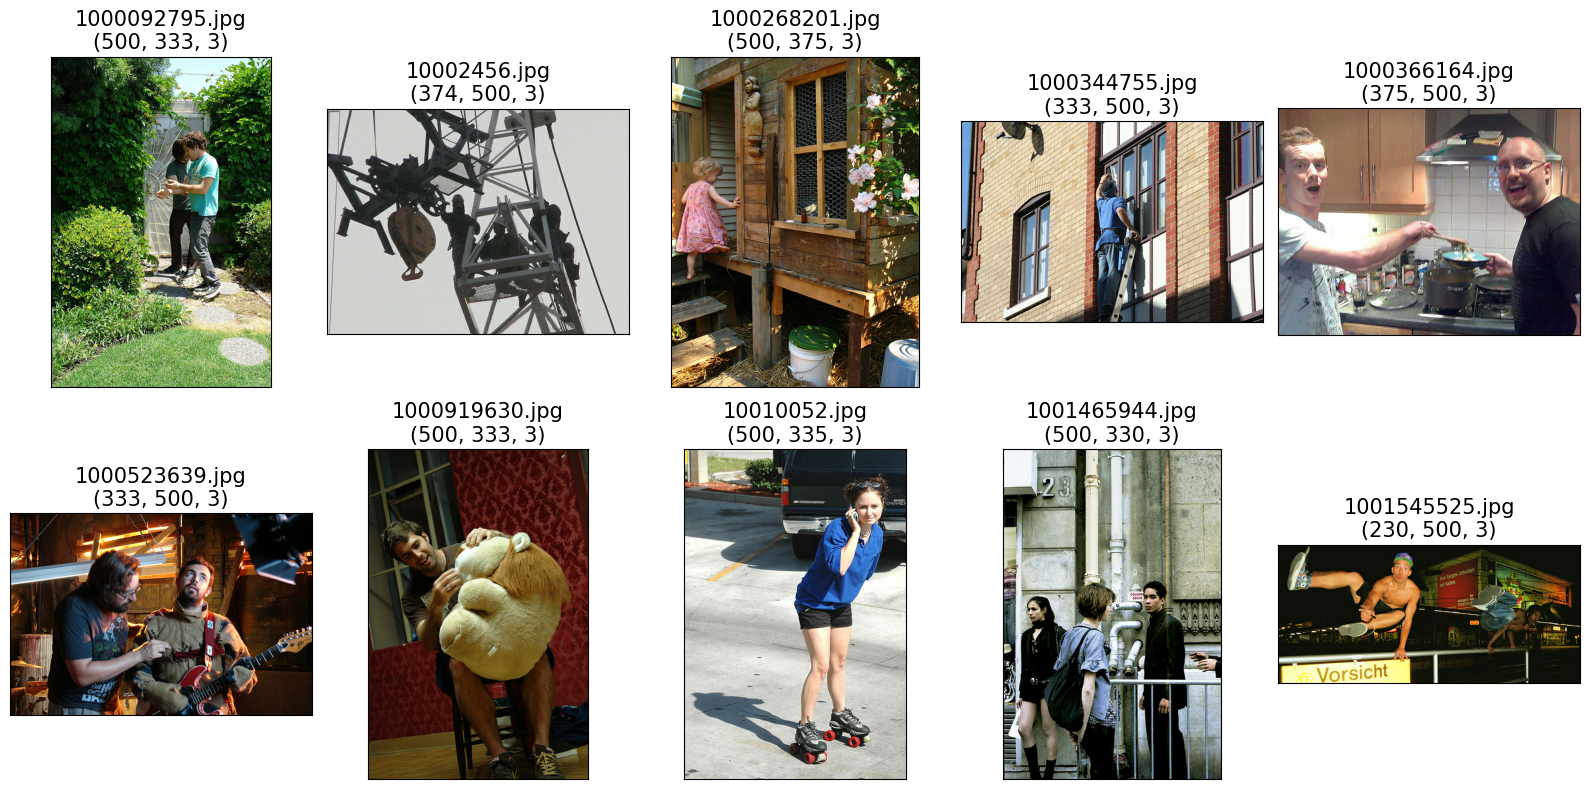

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pathlib

imgdir_path = pathlib.Path('/content/drive/MyDrive/flickr30k_images/flickr30k_images/')
img_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])

fig = plt.figure(figsize=(16, 8))
for i, f in enumerate(img_list[:10]):
  img_raw = tf.io.read_file(f)
  img = tf.image.decode_jpeg(img_raw).numpy()
  ax = fig.add_subplot(2, 5, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(f"{os.path.basename(f)}\n{img.shape}", size=15)
plt.tight_layout()
plt.show();

### Display captions in a dataframe

In [12]:
import pandas as pd

csv_path = "/content/drive/MyDrive/flickr30k_images/results.csv"
df = pd.read_csv(csv_path, delimiter='|')
df.head(12)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


In [14]:
df.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [15]:
df.columns = df.columns.str.strip()

In [16]:
df.describe()

,image_name,comment_number,comment
count,158915,158915,158914
unique,31783,6,158438
top,998845445.jpg,0,Two dogs playing in the snow .
freq,5,31783,7


In [17]:
# Save df
with open('/content/drive/MyDrive/flickr30k_images/df.pkl', 'wb') as f:
    pickle.dump(df, f)

### Define function to preprocess text and delimit each caption

In [18]:
import string
import nltk

table = str.maketrans('', '', string.punctuation)  # just delete punctuations

def text_preprocess(text):

  text = text.lower().split()
  text = [word for word in text if word.isalpha()]
  text = [w.translate(table) for w in text]
  text = [word for word in text if len(word)>1]
  text = "startseq "+' '.join(text)+ " endseq"

  return text

### Associates each image name with a list of preprocessed comments.

In [19]:
mapping =  {}
for i,c in zip(df.image_name, df.comment):
  if i in mapping.keys():  # if i in mapping:
    if(type(c)==str):
      mapping[i].append(text_preprocess(c))
  else:
    mapping[i]=[text_preprocess(c)]

# Save mapping
with open('/content/drive/MyDrive/flickr30k_images/mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

In [20]:
mapping['1006452823.jpg']

['startseq two children girl and boy are practicing their writing endseq',
 'startseq two children sit on small seesaw in the sand endseq',
 'startseq two children sitting on teeter totter endseq',
 'startseq kids playing on seesaw endseq',
 'startseq two kids sit on seesaw endseq']

### Estimation of caption length

In [21]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

# Save all_captions
with open('/content/drive/MyDrive/flickr30k_images/all_captions.pkl', 'wb') as f:
    pickle.dump(all_captions, f)


# Max length of the caption available
max_length_cap=max(len(caption.split())for caption in all_captions)
max_length_cap

74

### Extract vocabulary with tokenizer

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Save tokenizer
with open('/content/drive/MyDrive/flickr30k_images/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

vocab_dict = tokenizer.word_index
vocab_size = len(vocab_dict)+1         # total number of unique word, reserve index 0 for padding
vocab_size

17893

In [24]:
# Confirm startseq, endseq exists in tokens
print(tokenizer.word_index.get('startseq'))
print(tokenizer.word_index.get('endseq'))

1
2


In [25]:
# Save metadata
meta = {
    'vocab_dict': tokenizer.word_index,
    'vocab_size': len(tokenizer.word_index) + 1,
    'max_length_cap': max(len(c.split()) for c in all_captions)
}
with open('/content/drive/MyDrive/flickr30k_images/meta.pkl', 'wb') as f:
    pickle.dump(meta, f)

### Pretrained model for image feature extraction
About VGG: https://keras.io/api/applications/vgg/  Very Deep Convolutional Networks for Large-Scale Image Recognition.

VGG16 has been trained on a large subset of the ImageNet dataset, which contains over 14 million images, although the specific number of training images is about 1.2 million. The VGG16 model was designed to classify images into 1,000 object categories and achieved a high classification accuracy in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC)-2014.

### Setup VGG

In [26]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

vgg_model = VGG16(weights = 'imagenet')
# Trimming off the classification head and keeping the 4096-d feature vector from fc2
vgg_model = Model(inputs = vgg_model.inputs, outputs = vgg_model.layers[-2].output)
vgg_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

### Define function to extract features from images

In [27]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tqdm import tqdm  # for progress bar

def extract_feature(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # the input size expected by VGG16
    img_array = image.img_to_array(img)                     #convert the image pixel to a numpy array
    img_array = np.expand_dims(img_array, axis=0)           # to match batch input shape
    img_array = preprocess_input(img_array)                 # VGG16’s training requirement

    feature = model.predict(img_array, verbose=0)           # extract the feature vector from the fc2 layer
    return feature.flatten()

### Usage: call function

In [ ]:
# features_dict = extract_features(img_list, vgg_model)
# print(f"Extracted features for {len(features_dict)} images.")

### Checkpointing Feature Extraction
- Step 1: Save features incrementally

In [28]:
from tqdm import tqdm
import os
import pickle
from pathlib import Path

imgdir_path = Path('/content/drive/MyDrive/flickr30k_images/flickr30k_images/')
save_path = imgdir_path.parent / 'features'
os.makedirs(save_path, exist_ok=True)

img_paths = list(imgdir_path.glob("*.jpg"))

for img_path in tqdm(img_paths, desc="Extracting features"):
    img_name = img_path.name
    feature_file = save_path / img_name.replace('.jpg', '.pkl')

    if feature_file.exists():
        continue

    feature = extract_feature(str(img_path), vgg_model)
    img_id = img_name.split('.')[0]
    with open(feature_file, 'wb') as f:
        pickle.dump({img_id: feature}, f)

Extracting features: 100%|██████████| 31783/31783 [00:10<00:00, 2951.55it/s]


- Step 2: Resume from saved files
- After disconnecting runtime go back to Step 1 above

### Reconstructs features_dict in memory

In [29]:
from tqdm import tqdm
import pickle

features_dict = {}

# Wrap the iterable with tqdm to show progress
for file in tqdm(save_path.glob("*.pkl"), desc="Loading features"):
    with open(file, 'rb') as f:
        features = pickle.load(f)
        features_dict.update(features)

print(f"\nLoaded features for {len(features_dict)} images.")


Loading features: 31783it [4:44:41,  1.86it/s]


Loaded features for 31783 images.


### Pickle the hard earned features dictionary

In [30]:
import pickle

with open('/content/drive/MyDrive/flickr30k_images/features.pk', 'wb') as f:
    pickle.dump(features_dict, f)

In [31]:
!find /content -type f -name "features.pk"

/content/drive/MyDrive/flickr30k_images/features.pk


### Look at the feature vectors like a dataframe

In [32]:
import pandas as pd
import numpy as np

# Assuming features_dict maps image_id → np.array of shape (4096,)
df_features = pd.DataFrame.from_dict(features_dict, orient='index')

# Optional: add column names
df_features.columns = [f'feat_{i}' for i in range(df_features.shape[1])]

# Preview
df_features.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_4086,feat_4087,feat_4088,feat_4089,feat_4090,feat_4091,feat_4092,feat_4093,feat_4094,feat_4095
1451143609,1.150398,0.000000,0.0,0.000000,0.397537,0.0,0.000000,0.944667,0.060718,3.324188,...,0.946488,0.000000,1.403618,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1453423744,0.000000,0.000000,0.0,2.367716,0.000000,0.0,0.000000,0.046946,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.436009,0.0
1434090555,1.375335,3.524599,0.0,0.000000,5.078814,0.0,3.588328,0.000000,0.000000,1.768180,...,0.986403,0.000000,0.000000,0.0,0.000000,3.258337,0.0,3.354294,4.025799,0.0
1432342377,2.638278,0.000000,0.0,0.000000,0.153780,0.0,0.512540,2.656907,0.000000,0.408529,...,0.000000,0.000000,1.275504,0.0,0.000000,0.000000,0.0,0.000000,1.903264,0.0
1425919702,0.000000,0.000000,0.0,0.000000,3.169302,0.0,0.000000,0.849922,0.000000,2.402053,...,0.439638,0.043835,0.068556,0.0,0.411989,0.000000,0.0,0.000000,0.000000,0.0


👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇

### After yet another disconnection, to use pickled features mount the drive again
Retrive image features, df, mapping...

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Utility: Reload environment after runtime reset
import pickle

# Reload mapping
with open('/content/drive/MyDrive/flickr30k_images/mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)
print("Mapping loaded:", len(mapping))

# Reload all_captions
with open('/content/drive/MyDrive/flickr30k_images/all_captions.pkl', 'rb') as f:
    all_captions = pickle.load(f)
print("All captions loaded:", len(all_captions))

# Reload tokenizer
with open('/content/drive/MyDrive/flickr30k_images/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print("Tokenizer vocabulary size:", len(tokenizer.word_index))

# Reload metadata
with open('/content/drive/MyDrive/flickr30k_images/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
vocab_dict = meta['vocab_dict']
vocab_size = meta['vocab_size']
max_length_cap = meta['max_length_cap']
print("Vocab size:", vocab_size)
print("Max caption length:", max_length_cap)

# Reload image features
with open('/content/drive/MyDrive/flickr30k_images/features.pk', 'rb') as f:
    Img_features = pickle.load(f)
print(type(Img_features))  # should be dict
print("Image features loaded:", len(Img_features))

Mapping loaded: 31783
All captions loaded: 158914
Tokenizer vocabulary size: 17892
Vocab size: 17893
Max caption length: 74
<class 'dict'>
Image features loaded: 31783


### By splitting captions on image_ids, ensure that:

- Each image (and all its captions) is entirely in either train or test.

- Prevents data leakage across captions, the model never sees the same image in both phases.

In [5]:
#Train test split
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.9)

train_id = image_ids[:split]
print(len(train_id))

test_id = image_ids[split:]
print(len(test_id))

28604
3179


In [6]:
import random
for img_id in random.sample(train_id, 5):
    img_id=img_id.split('.')[0]
    print(img_id, np.mean(Img_features[img_id]), np.std(Img_features[img_id]))


241347204 0.5348875 1.4657232
4936289404 0.49194583 1.0066783
2069110603 0.35386193 0.7732222
4920970731 0.50309414 0.95872116
3217789209 0.64101195 1.2592314


### Construct a multimodel with functional API:


### Combining visual features from images and textual sequences from comments

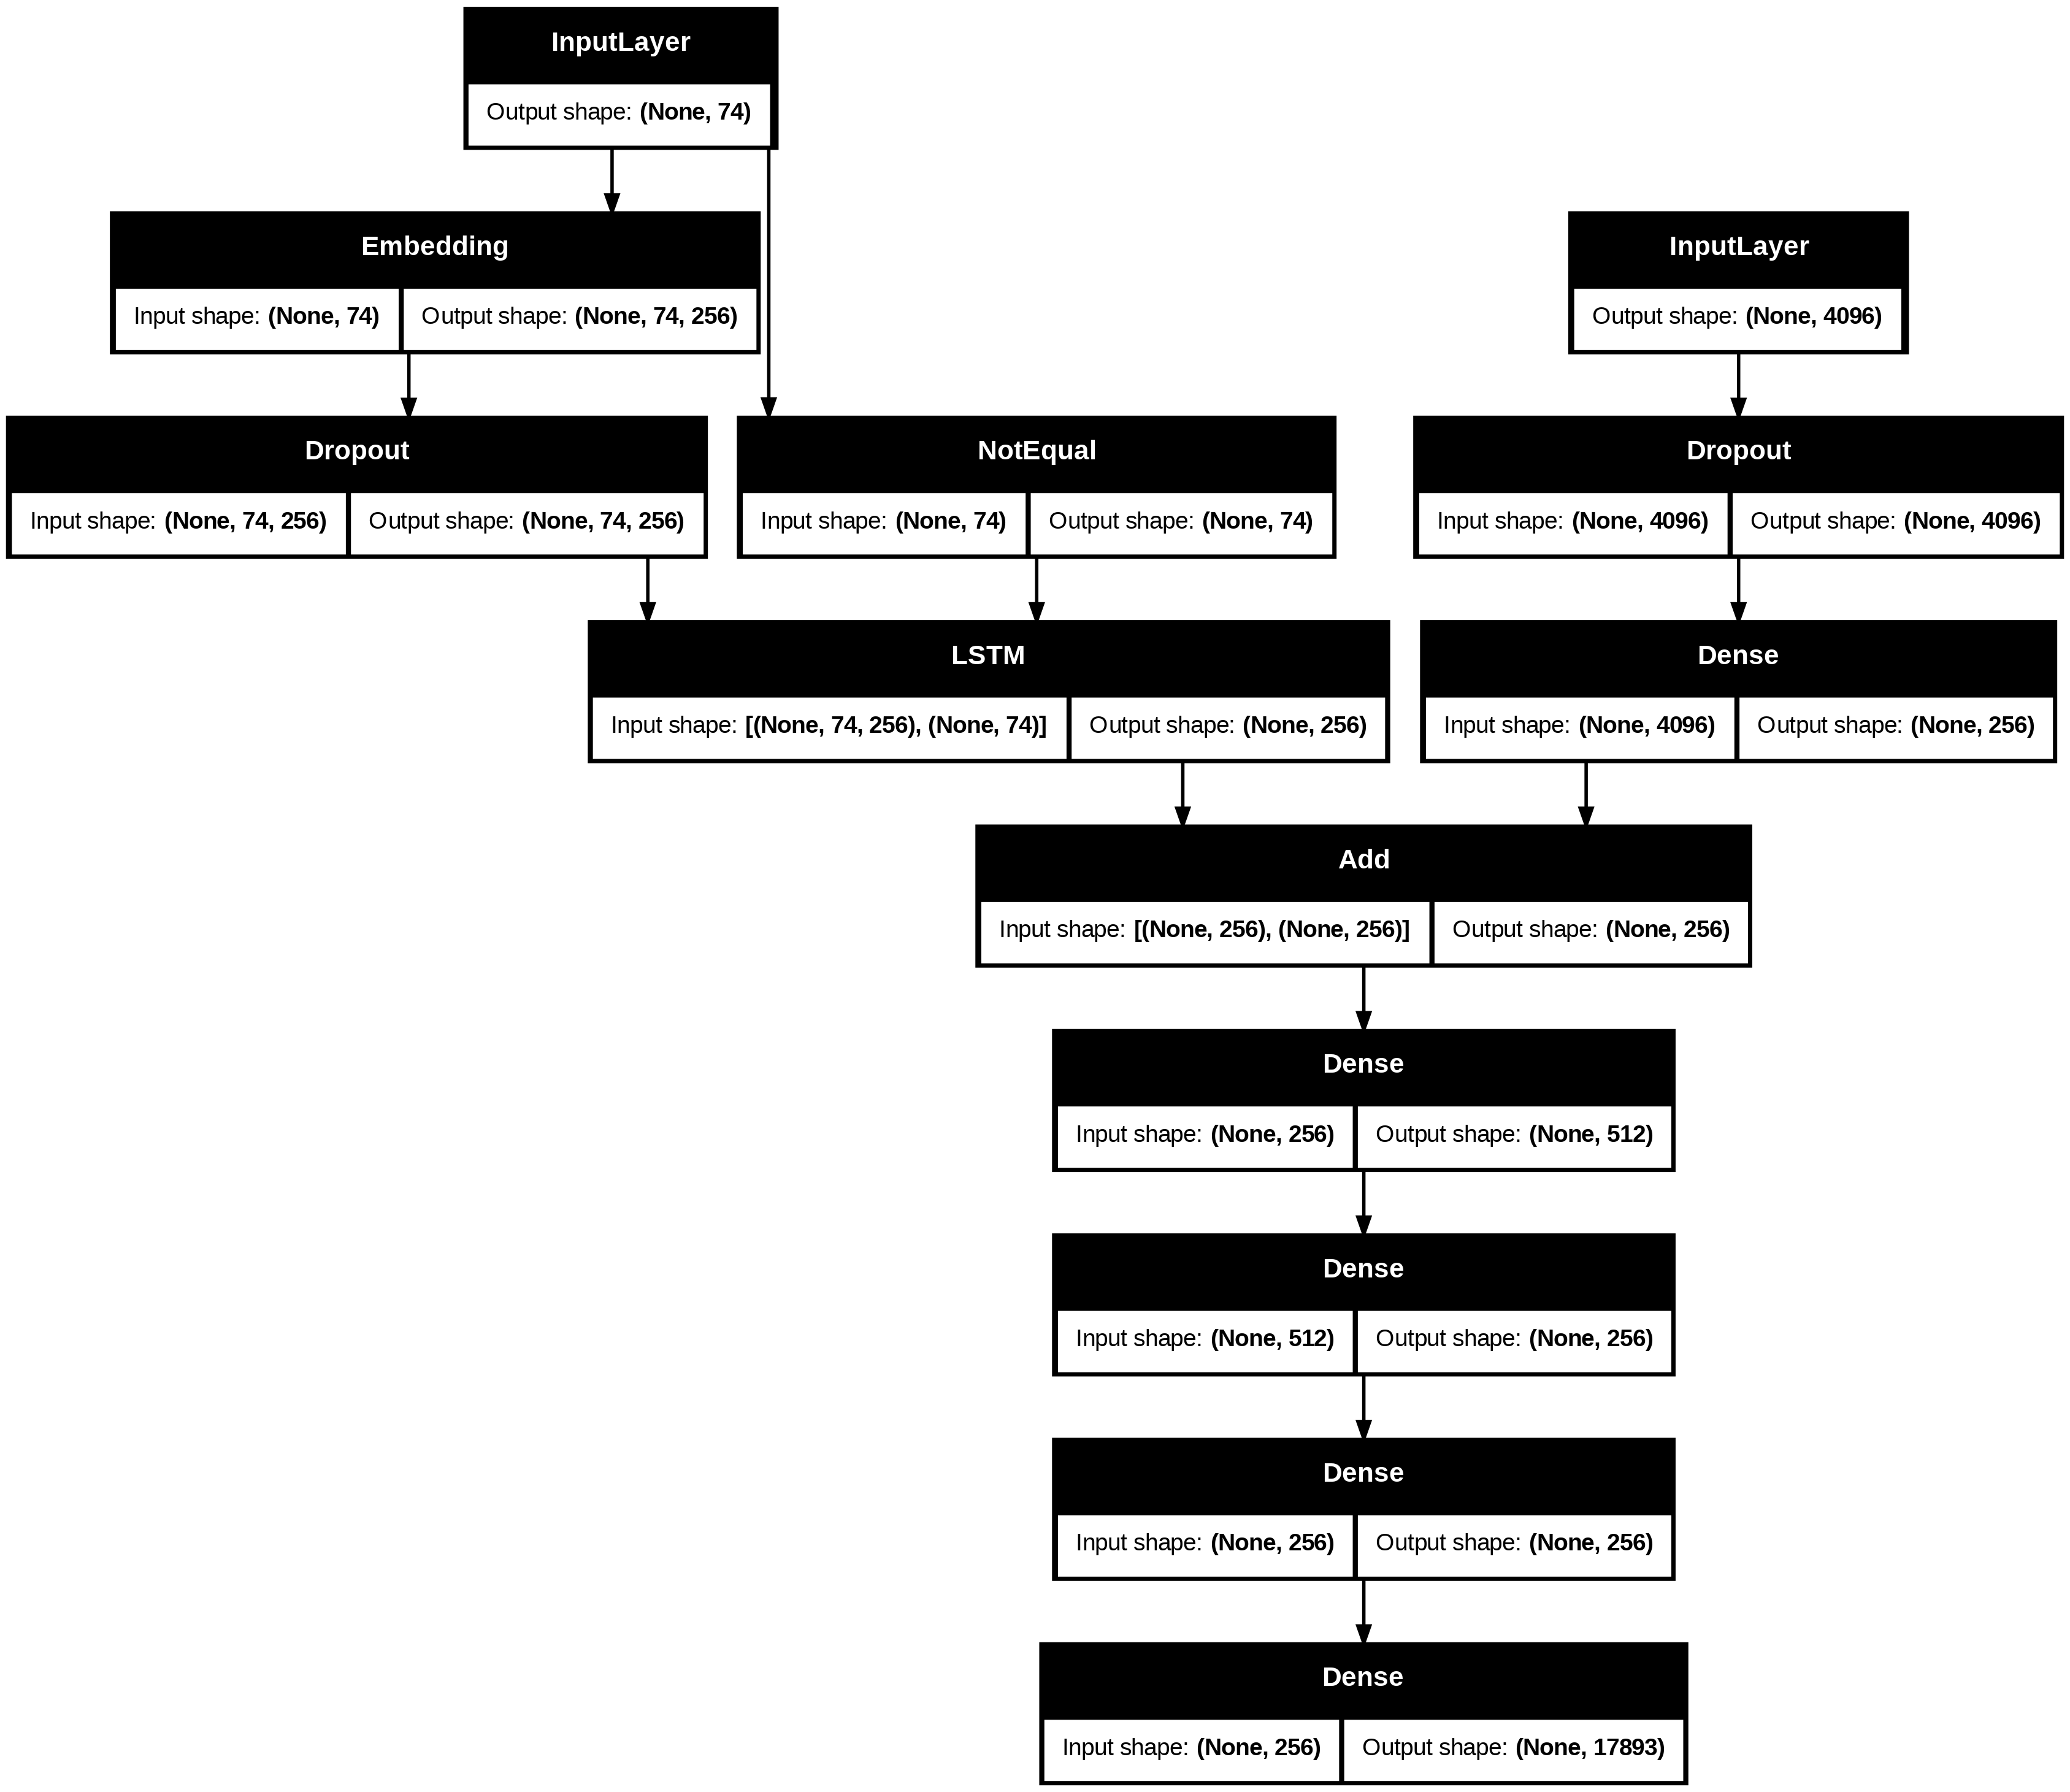

In [40]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Image Feature layers
inputs1 = Input(shape=(4096,))
Features1 = Dropout(0.0)(inputs1)
Features2 = Dense(256, activation='relu')(Features1)

# Text Feature layers
inputs2 = Input(shape=(max_length_cap,))
seq1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
seq2 = Dropout(0.0)(seq1)
seq3 =LSTM(256)(seq2)

# Fusion
fusion = add([Features2, seq3])
decoder1 = Dense(512, activation='relu')(fusion)
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = Dense(256, activation='relu')(decoder2)

# Output
outputs = Dense(vocab_size, activation='softmax')(decoder3)

# Functional API
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)


#plot the model
plot_model(model,show_shapes=True)

In [41]:
# One quick dummy forward pass
import numpy as np

dummy_img = np.random.rand(1, 4096)
dummy_seq = np.random.randint(1, vocab_size, size=(1, max_length_cap))

# softmax score, 1D array of probabilities over the vocabulary (vocab_size = 17892)
# the model's confidence that a particular word is the next in the caption
model.predict([dummy_img, dummy_seq])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


array([[5.5434015e-05, 5.4169988e-05, 5.3812557e-05, ..., 5.5883502e-05,
        5.3213680e-05, 5.5362962e-05]], dtype=float32)

In [42]:
image_id = train_id[0].split('.')[0]
print("Image vector mean/std:", np.mean(Img_features[image_id]), np.std(Img_features[image_id]))
print("Captions:", mapping[train_id[0]])


Image vector mean/std: 0.5966896 1.1497391
Captions: ['startseq there is parade going on in the street group of people are holding up an oscar the grouch float device endseq', 'startseq group of people march in parade on sunny day guiding an oscar the grouch float endseq', 'startseq multiple people carry sesame street float through the streets for parade endseq', 'startseq many people leading giant figure of oscar the grouch down street endseq', 'startseq group of people walking with large inflated oscar the grouch endseq']


### Define data generator to prepare training data for a multi-input model
**(image features, partial caption) → next word**

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random

def data_generator(data_keys, features, mapping, tokenizer, max_length, vocab_size, batch_size):
    """
    Generator that yields batches of training data for image captioning.
    Each sample consists of:
    - X1: image feature vector (from CNN)
    - X2: input sequence of word indices (padded)
    - y: target word index (integer, not one-hot)

    This version is optimized for use with sparse_categorical_crossentropy.
    """
    X1, X2, y = [], [], []
    n = 0

    while True:
        # Shuffle image keys to randomize batch order
        random.shuffle(data_keys)

        for key in data_keys:
            captions = mapping[key]

            # Process each caption associated with the current image
            for caption in captions:
                # Convert caption text to a sequence of token IDs
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate multiple input-output pairs from the sequence
                for i in range(1, len(seq)):
                    # Input sequence: all tokens before position i
                    in_seq = seq[:i]
                    # Output token: the token at position i
                    out_seq = seq[i]

                    # Skip if target word is padding (index 0)
                    if out_seq == 0:
                        continue

                    # Pad input sequence to fixed length
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                    # Get image ID (strip file extension)
                    image_id = key.split('.')[0]

                    # Sanity checks
                    assert image_id in features, f"Missing image_id: {image_id}"
                    assert features[image_id].shape == (4096,), f"Bad shape: {features[image_id].shape}"

                    # Append sample to batch buffers
                    X1.append(features[image_id])  # image features
                    X2.append(in_seq)              # input sequence
                    y.append(out_seq)              # target word index (integer)

                    n += 1  # Count samples

                    # Yield batch when full
                    if n == batch_size:
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []
                        n = 0

In [44]:
# Create a generator instance
test_generator = data_generator(
    data_keys = train_id,           # or test_id if you want to inspect test samples
    features = Img_features,
    mapping = mapping,
    tokenizer = tokenizer,
    max_length = max_length_cap,
    vocab_size = vocab_size,
    batch_size = 64                # match your training batch size
)

# Fetch one batch from the generator
(X1_batch, X2_batch), y_batch = next(test_generator)

# Print shapes to verify structure
print("Image vector shape:", X1_batch.shape)   # Expected: (64, 4096)
print("Caption input shape:", X2_batch.shape)  # Expected: (64, max_length)
print("Target shape:", y_batch.shape)          # Expected: (64, vocab_size)

# Fetch one batch from the generator
(X1_batch, X2_batch), y_batch = next(test_generator)

# Print shapes to verify structure
print("Image vector shape:", X1_batch.shape)   # Expected: (64, 4096)
print("Caption input shape:", X2_batch.shape)  # Expected: (64, max_length)
print("Target shape:", y_batch.shape)          # Expected: (64, vocab_size)

# Inspect one sample
print("\nSample image vector (mean/std):", np.mean(X1_batch[0]), np.std(X1_batch[0]))
print("Sample image vector [:20]:", X1_batch[0][:20])
print("Sample input sequence:", X2_batch[0])
print("Sample target word (one-hot):", np.argmax(y_batch[0]))


Image vector shape: (64, 4096)
Caption input shape: (64, 74)
Target shape: (64,)
Image vector shape: (64, 4096)
Caption input shape: (64, 74)
Target shape: (64,)

Sample image vector (mean/std): 0.4700787 1.2201405
Sample image vector [:20]: [2.2457604 0.        2.3236775 0.        2.1401625 2.4242759 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        1.128989  0.       ]
Sample input sequence: [  1  12  13 753   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Sample target word (one-hot): 0


In [45]:
for i in range(5):
    print(f"\nSample {i}")
    print("Input sequence:", X2_batch[i])
    print("Target word index:", np.argmax(y_batch[i]))



Sample 0
Input sequence: [  1  12  13 753   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Target word index: 0

Sample 1
Input sequence: [  1  12  13 753  60   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Target word index: 0

Sample 2
Input sequence: [  1  12  13 753  60  86   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

### Train the multimodel

A batch is a group of training samples where each sample consists of:
- A 4096-d image feature vector (from VGG16 fc2)
- A partial caption sequence (padded to max_length_cap)
- A target word (one-hot encoded over vocab_size)

Batch_size = 64 means:

Every training step processes 64 samples, not 64 images.
These samples may come from multiple images and captions.

The generator yields batches of shape:

- X1: (64, 4096) → image features
- X2: (64, max_length_cap) → input sequences
- y: (64, vocab_size) → target words

In [46]:
epochs = 100
batch_size = 64
steps = (len(train_id)//batch_size)

history_all = {'loss': [], 'accuracy': []}

for i in tqdm(range(epochs)):
    print('  Epoch:', i+1)
    generator = data_generator(train_id, Img_features, mapping, tokenizer, max_length_cap, vocab_size, batch_size)

    history = model.fit(generator, epochs=1, steps_per_epoch=steps, shuffle=True, verbose=1)

    # Save loss and accuracy
    history_all['loss'].append(history.history['loss'][0])
    history_all['accuracy'].append(history.history['accuracy'][0])


  0%|          | 0/100 [00:00<?, ?it/s]

  Epoch: 1
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.0758 - loss: 6.9968


  1%|          | 1/100 [00:09<15:43,  9.53s/it]

  Epoch: 2
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1349 - loss: 5.8371


  2%|▏         | 2/100 [00:17<13:50,  8.47s/it]

  Epoch: 3
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1628 - loss: 5.4325


  3%|▎         | 3/100 [00:25<13:14,  8.19s/it]

  Epoch: 4
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1755 - loss: 5.2396


  4%|▍         | 4/100 [00:32<12:33,  7.85s/it]

  Epoch: 5
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1910 - loss: 5.0167


  5%|▌         | 5/100 [00:40<12:26,  7.86s/it]

  Epoch: 6
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1972 - loss: 5.0463


  6%|▌         | 6/100 [00:47<12:00,  7.66s/it]

  Epoch: 7
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2117 - loss: 4.8739


  7%|▋         | 7/100 [00:55<11:57,  7.72s/it]

  Epoch: 8
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2098 - loss: 4.8293


  8%|▊         | 8/100 [01:03<11:53,  7.76s/it]

  Epoch: 9
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2172 - loss: 4.7085


  9%|▉         | 9/100 [01:10<11:33,  7.62s/it]

  Epoch: 10
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2166 - loss: 4.7747


 10%|█         | 10/100 [01:20<12:39,  8.44s/it]

  Epoch: 11
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2230 - loss: 4.7050


 11%|█         | 11/100 [01:31<13:21,  9.00s/it]

  Epoch: 12
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2333 - loss: 4.5239


 12%|█▏        | 12/100 [01:38<12:29,  8.51s/it]

  Epoch: 13
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2273 - loss: 4.6583


 13%|█▎        | 13/100 [01:46<12:04,  8.33s/it]

  Epoch: 14
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2334 - loss: 4.5651


 14%|█▍        | 14/100 [01:54<11:41,  8.16s/it]

  Epoch: 15
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2275 - loss: 4.6136


 15%|█▌        | 15/100 [02:01<11:16,  7.96s/it]

  Epoch: 16
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2368 - loss: 4.6035


 16%|█▌        | 16/100 [02:09<11:06,  7.94s/it]

  Epoch: 17
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2367 - loss: 4.4683


 17%|█▋        | 17/100 [02:16<10:43,  7.76s/it]

  Epoch: 18
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2367 - loss: 4.5085


 18%|█▊        | 18/100 [02:24<10:39,  7.80s/it]

  Epoch: 19
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2440 - loss: 4.4185


 19%|█▉        | 19/100 [02:32<10:30,  7.79s/it]

  Epoch: 20
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2404 - loss: 4.4744


 20%|██        | 20/100 [02:40<10:18,  7.74s/it]

  Epoch: 21
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2414 - loss: 4.4579


 21%|██        | 21/100 [02:48<10:17,  7.81s/it]

  Epoch: 22
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2338 - loss: 4.4008


 22%|██▏       | 22/100 [02:58<11:07,  8.55s/it]

  Epoch: 23
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2442 - loss: 4.3958


 23%|██▎       | 23/100 [03:05<10:34,  8.24s/it]

  Epoch: 24
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2453 - loss: 4.3792


 24%|██▍       | 24/100 [03:13<10:18,  8.14s/it]

  Epoch: 25
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2475 - loss: 4.3648


 25%|██▌       | 25/100 [03:21<09:54,  7.93s/it]

  Epoch: 26
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2572 - loss: 4.2888


 26%|██▌       | 26/100 [03:29<09:46,  7.93s/it]

  Epoch: 27
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2484 - loss: 4.3543


 27%|██▋       | 27/100 [03:37<09:38,  7.93s/it]

  Epoch: 28
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2576 - loss: 4.2666


 28%|██▊       | 28/100 [03:44<09:19,  7.77s/it]

  Epoch: 29
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2628 - loss: 4.2419


 29%|██▉       | 29/100 [03:52<09:14,  7.81s/it]

  Epoch: 30
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2572 - loss: 4.3186


 30%|███       | 30/100 [03:59<08:57,  7.68s/it]

  Epoch: 31
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2589 - loss: 4.1839


 31%|███       | 31/100 [04:07<08:55,  7.76s/it]

  Epoch: 32
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2550 - loss: 4.2617


 32%|███▏      | 32/100 [04:15<08:46,  7.75s/it]

  Epoch: 33
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2593 - loss: 4.2400


 33%|███▎      | 33/100 [04:23<08:34,  7.69s/it]

  Epoch: 34
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2555 - loss: 4.2130


 34%|███▍      | 34/100 [04:31<08:32,  7.77s/it]

  Epoch: 35
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2661 - loss: 4.1402


 35%|███▌      | 35/100 [04:38<08:17,  7.66s/it]

  Epoch: 36
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2599 - loss: 4.2122


 36%|███▌      | 36/100 [04:46<08:14,  7.72s/it]

  Epoch: 37
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2571 - loss: 4.2477


 37%|███▋      | 37/100 [04:53<08:06,  7.72s/it]

  Epoch: 38
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2706 - loss: 4.1236


 38%|███▊      | 38/100 [05:01<07:56,  7.68s/it]

  Epoch: 39
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2668 - loss: 4.2317


 39%|███▉      | 39/100 [05:09<07:53,  7.77s/it]

  Epoch: 40
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2659 - loss: 4.1007


 40%|████      | 40/100 [05:16<07:37,  7.63s/it]

  Epoch: 41
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2658 - loss: 4.1353


 41%|████      | 41/100 [05:27<08:16,  8.42s/it]

  Epoch: 42
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2563 - loss: 4.1638


 42%|████▏     | 42/100 [05:35<08:00,  8.28s/it]

  Epoch: 43
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2648 - loss: 4.0758


 43%|████▎     | 43/100 [05:42<07:36,  8.00s/it]

  Epoch: 44
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2641 - loss: 4.1680


 44%|████▍     | 44/100 [05:50<07:26,  7.97s/it]

  Epoch: 45
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2695 - loss: 4.0592


 45%|████▌     | 45/100 [05:57<07:11,  7.85s/it]

  Epoch: 46
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2672 - loss: 4.1473


 46%|████▌     | 46/100 [06:05<07:01,  7.81s/it]

  Epoch: 47
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2703 - loss: 4.1211


 47%|████▋     | 47/100 [06:13<06:55,  7.85s/it]

  Epoch: 48
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2632 - loss: 4.1478


 48%|████▊     | 48/100 [06:20<06:41,  7.72s/it]

  Epoch: 49
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2748 - loss: 4.0657


 49%|████▉     | 49/100 [06:28<06:37,  7.79s/it]

  Epoch: 50
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2635 - loss: 4.0845


 50%|█████     | 50/100 [06:36<06:24,  7.70s/it]

  Epoch: 51
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2629 - loss: 4.0510


 51%|█████     | 51/100 [06:44<06:19,  7.74s/it]

  Epoch: 52
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2697 - loss: 4.0552


 52%|█████▏    | 52/100 [06:52<06:14,  7.80s/it]

  Epoch: 53
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2668 - loss: 4.0537


 53%|█████▎    | 53/100 [06:59<06:01,  7.68s/it]

  Epoch: 54
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2690 - loss: 4.1049


 54%|█████▍    | 54/100 [07:07<05:57,  7.77s/it]

  Epoch: 55
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2696 - loss: 4.0433


 55%|█████▌    | 55/100 [07:15<05:45,  7.68s/it]

  Epoch: 56
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2706 - loss: 4.0634


 56%|█████▌    | 56/100 [07:25<06:12,  8.46s/it]

  Epoch: 57
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2755 - loss: 4.0175


 57%|█████▋    | 57/100 [07:35<06:27,  9.01s/it]

  Epoch: 58
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2697 - loss: 4.0416


 58%|█████▊    | 58/100 [07:43<06:05,  8.70s/it]

  Epoch: 59
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2673 - loss: 4.1040


 59%|█████▉    | 59/100 [07:51<05:40,  8.31s/it]

  Epoch: 60
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2772 - loss: 3.9866


 60%|██████    | 60/100 [07:58<05:27,  8.19s/it]

  Epoch: 61
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2825 - loss: 4.0570


 61%|██████    | 61/100 [08:06<05:10,  7.97s/it]

  Epoch: 62
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2757 - loss: 3.9867


 62%|██████▏   | 62/100 [08:14<05:02,  7.96s/it]

  Epoch: 63
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2789 - loss: 4.0115


 63%|██████▎   | 63/100 [08:22<04:54,  7.96s/it]

  Epoch: 64
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2717 - loss: 4.0306


 64%|██████▍   | 64/100 [08:29<04:40,  7.78s/it]

  Epoch: 65
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2765 - loss: 4.0579


 65%|██████▌   | 65/100 [08:37<04:33,  7.82s/it]

  Epoch: 66
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2744 - loss: 4.0470


 66%|██████▌   | 66/100 [08:44<04:21,  7.69s/it]

  Epoch: 67
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2777 - loss: 4.0497


 67%|██████▋   | 67/100 [08:52<04:15,  7.74s/it]

  Epoch: 68
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2687 - loss: 4.0291


 68%|██████▊   | 68/100 [09:00<04:08,  7.77s/it]

  Epoch: 69
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2744 - loss: 3.9569


 69%|██████▉   | 69/100 [09:08<03:58,  7.70s/it]

  Epoch: 70
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2681 - loss: 4.0202


 70%|███████   | 70/100 [09:18<04:14,  8.48s/it]

  Epoch: 71
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2796 - loss: 3.9564


 71%|███████   | 71/100 [09:26<04:00,  8.30s/it]

  Epoch: 72
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2748 - loss: 4.0478


 72%|███████▏  | 72/100 [09:33<03:46,  8.08s/it]

  Epoch: 73
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2702 - loss: 3.9941


 73%|███████▎  | 73/100 [09:41<03:37,  8.06s/it]

  Epoch: 74
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2780 - loss: 3.9190


 74%|███████▍  | 74/100 [09:49<03:24,  7.88s/it]

  Epoch: 75
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2851 - loss: 3.9775


 75%|███████▌  | 75/100 [09:57<03:17,  7.90s/it]

  Epoch: 76
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2854 - loss: 3.9323


 76%|███████▌  | 76/100 [10:05<03:09,  7.89s/it]

  Epoch: 77
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2852 - loss: 3.9412


 77%|███████▋  | 77/100 [10:12<02:59,  7.79s/it]

  Epoch: 78
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2785 - loss: 3.8947


 78%|███████▊  | 78/100 [10:20<02:52,  7.83s/it]

  Epoch: 79
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2824 - loss: 3.9661


 79%|███████▉  | 79/100 [10:28<02:41,  7.69s/it]

  Epoch: 80
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2846 - loss: 3.9036


 80%|████████  | 80/100 [10:35<02:35,  7.76s/it]

  Epoch: 81
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2822 - loss: 3.8900


 81%|████████  | 81/100 [10:43<02:27,  7.77s/it]

  Epoch: 82
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2798 - loss: 3.8985


 82%|████████▏ | 82/100 [10:51<02:18,  7.71s/it]

  Epoch: 83
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2772 - loss: 3.9098


 83%|████████▎ | 83/100 [10:59<02:12,  7.78s/it]

  Epoch: 84
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2745 - loss: 4.0206


 84%|████████▍ | 84/100 [11:09<02:16,  8.53s/it]

  Epoch: 85
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2784 - loss: 3.9800


 85%|████████▌ | 85/100 [11:17<02:03,  8.22s/it]

  Epoch: 86
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2730 - loss: 3.9743


 86%|████████▌ | 86/100 [11:27<02:03,  8.84s/it]

  Epoch: 87
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2810 - loss: 3.9243


 87%|████████▋ | 87/100 [11:37<02:00,  9.27s/it]

  Epoch: 88
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2758 - loss: 4.0503


 88%|████████▊ | 88/100 [11:45<01:44,  8.73s/it]

  Epoch: 89
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2807 - loss: 3.9427


 89%|████████▉ | 89/100 [11:53<01:33,  8.51s/it]

  Epoch: 90
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2747 - loss: 3.9448


 90%|█████████ | 90/100 [12:00<01:23,  8.32s/it]

  Epoch: 91
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2818 - loss: 3.8426


 91%|█████████ | 91/100 [12:11<01:20,  8.92s/it]

  Epoch: 92
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2856 - loss: 3.8710


 92%|█████████▏| 92/100 [12:19<01:09,  8.66s/it]

  Epoch: 93
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2755 - loss: 3.9450


 93%|█████████▎| 93/100 [12:27<00:59,  8.46s/it]

  Epoch: 94
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2878 - loss: 3.8947


 94%|█████████▍| 94/100 [12:34<00:48,  8.15s/it]

  Epoch: 95
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2810 - loss: 3.9180


 95%|█████████▌| 95/100 [12:42<00:40,  8.10s/it]

  Epoch: 96
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2873 - loss: 3.9407


 96%|█████████▌| 96/100 [12:50<00:31,  7.91s/it]

  Epoch: 97
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2782 - loss: 3.9434


 97%|█████████▋| 97/100 [12:58<00:23,  7.94s/it]

  Epoch: 98
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2798 - loss: 3.8968


 98%|█████████▊| 98/100 [13:06<00:15,  7.96s/it]

  Epoch: 99
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2821 - loss: 3.8505


 99%|█████████▉| 99/100 [13:13<00:07,  7.82s/it]

  Epoch: 100
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2875 - loss: 3.7927


100%|██████████| 100/100 [13:21<00:00,  8.02s/it]


### Save the fitted model

In [47]:
model.save('/content/drive/MyDrive/flickr30k_images/Img_Model.keras')

### Resume training

In [56]:
start_epoch = 101
total_epochs = 200

for i in tqdm(range(start_epoch, total_epochs + 1)):
    print('  Epoch:', i)
    generator = data_generator(train_id, Img_features, mapping, tokenizer, max_length_cap, vocab_size, batch_size)

    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    history_all['loss'].append(history.history['loss'][0])
    history_all['accuracy'].append(history.history['accuracy'][0])


  0%|          | 0/100 [00:00<?, ?it/s]

  Epoch: 101
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.2874 - loss: 3.8811


  1%|          | 1/100 [00:08<14:27,  8.76s/it]

  Epoch: 102
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2831 - loss: 3.9642


  2%|▏         | 2/100 [00:16<13:23,  8.20s/it]

  Epoch: 103
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2805 - loss: 3.8800


  3%|▎         | 3/100 [00:24<12:57,  8.02s/it]

  Epoch: 104
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2808 - loss: 3.9559


  4%|▍         | 4/100 [00:31<12:29,  7.80s/it]

  Epoch: 105
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2869 - loss: 3.8465


  5%|▌         | 5/100 [00:42<13:45,  8.69s/it]

  Epoch: 106
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2926 - loss: 3.8311


  6%|▌         | 6/100 [00:49<13:06,  8.37s/it]

  Epoch: 107
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2963 - loss: 3.8288


  7%|▋         | 7/100 [00:57<12:30,  8.07s/it]

  Epoch: 108
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2850 - loss: 3.8888


  8%|▊         | 8/100 [01:05<12:14,  7.98s/it]

  Epoch: 109
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2903 - loss: 3.8892


  9%|▉         | 9/100 [01:12<11:47,  7.77s/it]

  Epoch: 110
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3020 - loss: 3.7621


 10%|█         | 10/100 [01:20<11:40,  7.79s/it]

  Epoch: 111
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2982 - loss: 3.7225


 11%|█         | 11/100 [01:27<11:25,  7.70s/it]

  Epoch: 112
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2781 - loss: 3.8811


 12%|█▏        | 12/100 [01:35<11:16,  7.68s/it]

  Epoch: 113
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2777 - loss: 3.9241


 13%|█▎        | 13/100 [01:45<12:16,  8.47s/it]

  Epoch: 114
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2908 - loss: 3.8167


 14%|█▍        | 14/100 [01:53<11:42,  8.17s/it]

  Epoch: 115
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2882 - loss: 3.8051


 15%|█▌        | 15/100 [02:00<11:23,  8.04s/it]

  Epoch: 116
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2870 - loss: 3.8187


 16%|█▌        | 16/100 [02:11<12:11,  8.71s/it]

  Epoch: 117
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2899 - loss: 3.7706


 17%|█▋        | 17/100 [02:18<11:29,  8.31s/it]

  Epoch: 118
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2866 - loss: 3.9056


 18%|█▊        | 18/100 [02:26<11:09,  8.16s/it]

  Epoch: 119
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2847 - loss: 3.8413


 19%|█▉        | 19/100 [02:34<10:53,  8.07s/it]

  Epoch: 120
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2854 - loss: 3.8575


 20%|██        | 20/100 [02:41<10:28,  7.86s/it]

  Epoch: 121
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2866 - loss: 3.7903


 21%|██        | 21/100 [02:51<11:18,  8.58s/it]

  Epoch: 122
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2878 - loss: 3.8384


 22%|██▏       | 22/100 [02:59<10:51,  8.35s/it]

  Epoch: 123
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2866 - loss: 3.9060


 23%|██▎       | 23/100 [03:07<10:21,  8.07s/it]

  Epoch: 124
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2943 - loss: 3.8143


 24%|██▍       | 24/100 [03:14<10:08,  8.01s/it]

  Epoch: 125
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2877 - loss: 3.8339


 25%|██▌       | 25/100 [03:22<09:46,  7.82s/it]

  Epoch: 126
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2866 - loss: 3.8878


 26%|██▌       | 26/100 [03:30<09:39,  7.83s/it]

  Epoch: 127
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2929 - loss: 3.7830


 27%|██▋       | 27/100 [03:37<09:27,  7.77s/it]

  Epoch: 128
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2929 - loss: 3.7870


 28%|██▊       | 28/100 [03:48<10:14,  8.53s/it]

  Epoch: 129
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2847 - loss: 3.8509


 29%|██▉       | 29/100 [03:56<09:52,  8.34s/it]

  Epoch: 130
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2857 - loss: 3.8877


 30%|███       | 30/100 [04:03<09:30,  8.15s/it]

  Epoch: 131
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2922 - loss: 3.8249


 31%|███       | 31/100 [04:11<09:10,  7.97s/it]

  Epoch: 132
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2842 - loss: 3.7682


 32%|███▏      | 32/100 [04:19<09:00,  7.95s/it]

  Epoch: 133
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2906 - loss: 3.8376


 33%|███▎      | 33/100 [04:26<08:40,  7.77s/it]

  Epoch: 134
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2888 - loss: 3.7564


 34%|███▍      | 34/100 [04:36<09:22,  8.52s/it]

  Epoch: 135
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2937 - loss: 3.8457


 35%|███▌      | 35/100 [04:44<09:02,  8.34s/it]

  Epoch: 136
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2839 - loss: 3.9004


 36%|███▌      | 36/100 [04:52<08:34,  8.05s/it]

  Epoch: 137
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2920 - loss: 3.8456


 37%|███▋      | 37/100 [04:59<08:23,  7.99s/it]

  Epoch: 138
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2928 - loss: 3.7978


 38%|███▊      | 38/100 [05:07<08:04,  7.82s/it]

  Epoch: 139
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2823 - loss: 3.8268


 39%|███▉      | 39/100 [05:15<07:55,  7.80s/it]

  Epoch: 140
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2889 - loss: 3.9099


 40%|████      | 40/100 [05:22<07:49,  7.83s/it]

  Epoch: 141
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2926 - loss: 3.7587


 41%|████      | 41/100 [05:30<07:33,  7.68s/it]

  Epoch: 142
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2958 - loss: 3.8094


 42%|████▏     | 42/100 [05:38<07:28,  7.74s/it]

  Epoch: 143
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2982 - loss: 3.7397


 43%|████▎     | 43/100 [05:45<07:15,  7.64s/it]

  Epoch: 144
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2931 - loss: 3.7803


 44%|████▍     | 44/100 [05:55<07:52,  8.44s/it]

  Epoch: 145
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2934 - loss: 3.7788


 45%|████▌     | 45/100 [06:03<07:35,  8.29s/it]

  Epoch: 146
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2905 - loss: 3.7799


 46%|████▌     | 46/100 [06:11<07:11,  8.00s/it]

  Epoch: 147
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2991 - loss: 3.7355


 47%|████▋     | 47/100 [06:19<07:02,  7.97s/it]

  Epoch: 148
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2918 - loss: 3.7989


 48%|████▊     | 48/100 [06:26<06:51,  7.91s/it]

  Epoch: 149
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2932 - loss: 3.8252


 49%|████▉     | 49/100 [06:34<06:37,  7.78s/it]

  Epoch: 150
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2909 - loss: 3.7587


 50%|█████     | 50/100 [06:42<06:29,  7.80s/it]

  Epoch: 151
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2889 - loss: 3.8134


 51%|█████     | 51/100 [06:49<06:16,  7.68s/it]

  Epoch: 152
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2919 - loss: 3.7878


 52%|█████▏    | 52/100 [06:57<06:11,  7.74s/it]

  Epoch: 153
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2896 - loss: 3.8034


 53%|█████▎    | 53/100 [07:05<06:02,  7.72s/it]

  Epoch: 154
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2894 - loss: 3.7845


 54%|█████▍    | 54/100 [07:15<06:30,  8.50s/it]

  Epoch: 155
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2912 - loss: 3.8083


 55%|█████▌    | 55/100 [07:23<06:14,  8.33s/it]

  Epoch: 156
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2916 - loss: 3.8545


 56%|█████▌    | 56/100 [07:31<05:57,  8.12s/it]

  Epoch: 157
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2892 - loss: 3.7989


 57%|█████▋    | 57/100 [07:38<05:42,  7.96s/it]

  Epoch: 158
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2939 - loss: 3.8051


 58%|█████▊    | 58/100 [07:46<05:33,  7.94s/it]

  Epoch: 159
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2968 - loss: 3.7707


 59%|█████▉    | 59/100 [07:53<05:18,  7.76s/it]

  Epoch: 160
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2996 - loss: 3.7971


 60%|██████    | 60/100 [08:01<05:11,  7.80s/it]

  Epoch: 161
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3016 - loss: 3.7545


 61%|██████    | 61/100 [08:09<05:00,  7.72s/it]

  Epoch: 162
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2989 - loss: 3.7716


 62%|██████▏   | 62/100 [08:16<04:53,  7.72s/it]

  Epoch: 163
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2955 - loss: 3.8283


 63%|██████▎   | 63/100 [08:24<04:47,  7.77s/it]

  Epoch: 164
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2992 - loss: 3.7861


 64%|██████▍   | 64/100 [08:32<04:35,  7.64s/it]

  Epoch: 165
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2958 - loss: 3.7906


 65%|██████▌   | 65/100 [08:40<04:30,  7.72s/it]

  Epoch: 166
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2871 - loss: 3.8237


 66%|██████▌   | 66/100 [08:47<04:19,  7.65s/it]

  Epoch: 167
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2924 - loss: 3.7652


 67%|██████▋   | 67/100 [08:55<04:14,  7.70s/it]

  Epoch: 168
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2989 - loss: 3.6949


 68%|██████▊   | 68/100 [09:05<04:31,  8.47s/it]

  Epoch: 169
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2918 - loss: 3.7939


 69%|██████▉   | 69/100 [09:13<04:13,  8.16s/it]

  Epoch: 170
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2983 - loss: 3.7560


 70%|███████   | 70/100 [09:21<04:02,  8.09s/it]

  Epoch: 171
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2941 - loss: 3.8293


 71%|███████   | 71/100 [09:29<03:53,  8.05s/it]

  Epoch: 172
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2908 - loss: 3.8432


 72%|███████▏  | 72/100 [09:36<03:39,  7.85s/it]

  Epoch: 173
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2891 - loss: 3.8093


 73%|███████▎  | 73/100 [09:44<03:32,  7.88s/it]

  Epoch: 174
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2958 - loss: 3.7895


 74%|███████▍  | 74/100 [09:51<03:20,  7.72s/it]

  Epoch: 175
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2944 - loss: 3.8219


 75%|███████▌  | 75/100 [09:59<03:14,  7.79s/it]

  Epoch: 176
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2965 - loss: 3.7487


 76%|███████▌  | 76/100 [10:07<03:06,  7.78s/it]

  Epoch: 177
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2979 - loss: 3.7585


 77%|███████▋  | 77/100 [10:14<02:56,  7.68s/it]

  Epoch: 178
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2961 - loss: 3.7193


 78%|███████▊  | 78/100 [10:22<02:50,  7.75s/it]

  Epoch: 179
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2931 - loss: 3.7565


 79%|███████▉  | 79/100 [10:30<02:40,  7.64s/it]

  Epoch: 180
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3011 - loss: 3.7036


 80%|████████  | 80/100 [10:40<02:48,  8.43s/it]

  Epoch: 181
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3011 - loss: 3.7259


 81%|████████  | 81/100 [10:50<02:50,  8.98s/it]

  Epoch: 182
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3035 - loss: 3.7446


 82%|████████▏ | 82/100 [10:58<02:35,  8.63s/it]

  Epoch: 183
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2978 - loss: 3.7700


 83%|████████▎ | 83/100 [11:06<02:21,  8.33s/it]

  Epoch: 184
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3015 - loss: 3.7151


 84%|████████▍ | 84/100 [11:14<02:11,  8.21s/it]

  Epoch: 185
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2901 - loss: 3.7954


 85%|████████▌ | 85/100 [11:21<01:59,  7.97s/it]

  Epoch: 186
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2985 - loss: 3.7329


 86%|████████▌ | 86/100 [11:29<01:51,  7.97s/it]

  Epoch: 187
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2979 - loss: 3.7113


 87%|████████▋ | 87/100 [11:37<01:42,  7.87s/it]

  Epoch: 188
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2988 - loss: 3.7095


 88%|████████▊ | 88/100 [11:47<01:43,  8.60s/it]

  Epoch: 189
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3033 - loss: 3.6672


 89%|████████▉ | 89/100 [11:55<01:32,  8.41s/it]

  Epoch: 190
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2992 - loss: 3.7252


 90%|█████████ | 90/100 [12:02<01:21,  8.18s/it]

  Epoch: 191
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3040 - loss: 3.7200


 91%|█████████ | 91/100 [12:10<01:12,  8.04s/it]

  Epoch: 192
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2987 - loss: 3.7300


 92%|█████████▏| 92/100 [12:20<01:09,  8.71s/it]

  Epoch: 193
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2858 - loss: 3.8035


 93%|█████████▎| 93/100 [12:31<01:04,  9.18s/it]

  Epoch: 194
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2927 - loss: 3.7492


 94%|█████████▍| 94/100 [12:38<00:52,  8.69s/it]

  Epoch: 195
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2987 - loss: 3.6894


 95%|█████████▌| 95/100 [12:49<00:45,  9.17s/it]

  Epoch: 196
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2919 - loss: 3.8018


 96%|█████████▌| 96/100 [12:57<00:35,  8.84s/it]

  Epoch: 197
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2966 - loss: 3.8018


 97%|█████████▋| 97/100 [13:04<00:25,  8.46s/it]

  Epoch: 198
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2977 - loss: 3.7518


 98%|█████████▊| 98/100 [13:12<00:16,  8.33s/it]

  Epoch: 199
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3015 - loss: 3.6950


 99%|█████████▉| 99/100 [13:20<00:08,  8.15s/it]

  Epoch: 200
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2976 - loss: 3.8084


100%|██████████| 100/100 [13:28<00:00,  8.08s/it]


### Save again

In [57]:
model.save('/content/drive/MyDrive/flickr30k_images/Img_Model.keras')

### Load model after reconnect
... import and mount ...

In [58]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/flickr30k_images/Img_Model.keras')

### Plot the learning curve

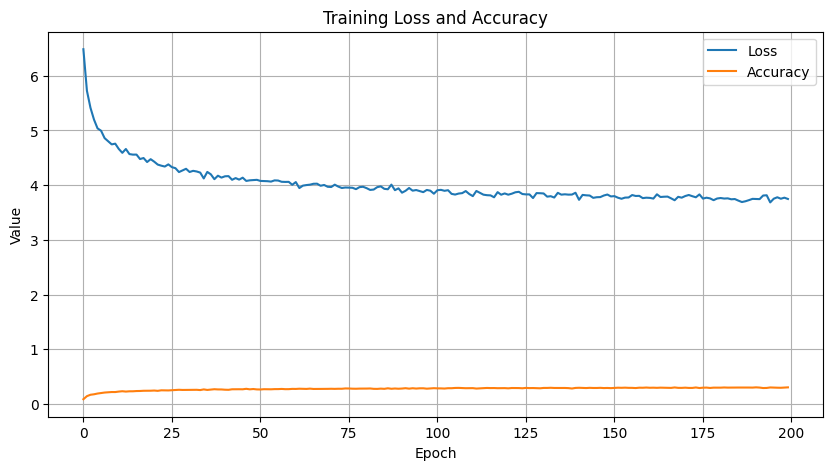

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_all['loss'], label='Loss')
plt.plot(history_all['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Generate captions for images



In [60]:
# Index to word: Use the built-in reverse mapping
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer)

In [61]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'  # Match preprocessing exactly
    for _ in range(max_length):
        # Encode and pad input sequence
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')

        # Predict the next word
        yhat = model.predict([image, seq], verbose=0)
        next_index = np.argmax(yhat)
        next_word = idx_to_word(next_index, tokenizer)

        # Stop if word is unknown or end token
        if next_word is None or next_word == 'endseq':
            break

        # Append word to input sequence
        in_text += ' ' + next_word

    return in_text.replace('startseq', '').strip()

In [62]:
import matplotlib.pyplot as plt
from PIL import Image
import os

BASE_DIR = '/content/drive/MyDrive/flickr30k_images/flickr30k_images/'

def visualize_prediction(image_name):
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print('_______________________Actual_________________')
    for caption in mapping[image_id + '.jpg']:
        print(caption.replace('startseq', '').replace('endseq', '').strip())

    y_pred = predict_caption(model, Img_features[image_id].reshape(1, 4096), tokenizer, max_length_cap)
    print('_____________________Predicted________________')
    print(y_pred)


### Test captioning for a random image

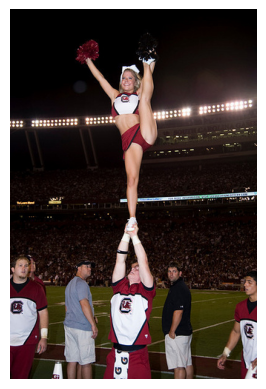

_______________________Actual_________________
female cheerleader is being held up by one male cheerleader while two other male cheerleaders stand to the side
male cheerleader is holding female cheerleader in the air at football game
cheerleaders are doing routine at football game while several men watch
male cheerleader holding female cheerleader up during football game
group of cheerleaders perform at football game
_____________________Predicted________________
man in blue shirt and black pants is playing tennis


In [63]:
import random

# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)


In [64]:
test_id1=test_id[:10]
test_id1

['6337872636.jpg',
 '6337899496.jpg',
 '6338098558.jpg',
 '6338542128.jpg',
 '6338544926.jpg',
 '6338704.jpg',
 '6338733.jpg',
 '6339096.jpg',
 '6339576648.jpg',
 '6339590254.jpg']

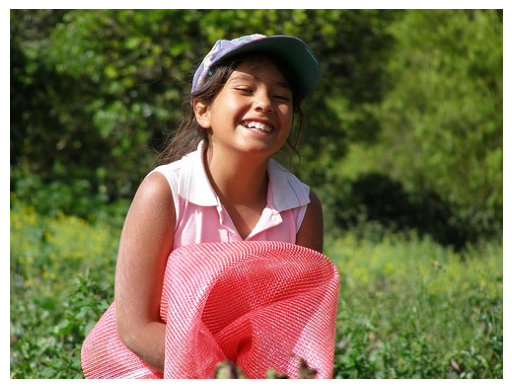

_______________________Actual_________________
an asian girl in pink dress is smiling whilst out in the countryside
smiling girl in hat carrying striped cloth in field
young smiling girl in hat crouched in field
girl in pink outfit and blue cap laughs
young girl laughing
_____________________Predicted________________
man in black shirt is sitting on the floor with his hands on his head


In [65]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)